# Importing Libraries

In [1]:
import juliet
import os
import sys

from sympy import *
from numpy import *
from tabulate import tabulate
from colorama import*
from matplotlib.offsetbox import*

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

font1 = {'family':'serif','color':'black'}

C:\Users\computer\anaconda3\lib\site-packages\autograd\numpy\numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


problem: Could not find module 'libmultinest.dll' (or one of its dependencies). Try using the full path with constructor syntax.


# Define Priors

In [2]:
# Name of Target Star
# Leave one space between TOI and ID i.e., TOI 1148
Target_Star = 'TOI 2443'

# -------------------------------------------------
# Some User inputs !!
# [value, uncertainty]
# -------------------------------------------------
magnitude, mag_err = [8.2969, 0.006]                
mass_of_the_host_star_in_solar_masses, m_err = [0.66, 0.0789265] 
radius_of_the_host_star_in_solar_radius, r_err = [0.732115, 0.0713468]
temperature_of_the_host_star, t_err = [4357, 100]
luminosity, l_err = [0.1523396, 0.01097705]
# -------------------------------------------------
# Normal Distribution: [mean value, deviation]
# Uniform Distribution: [minimum value, maximum value]
# -------------------------------------------------
Period, Period_Deviation = [15.6692, 0.1]         # Normal Distribution
Time, Time_Deviation = [2457000 + 2148.098617, 0.1]   # Normal Distribution
a_lower, a_upper = [1, 100]                 # Uniform distribution
# -------------------------------------------------

filename = 'Detrended & Combined Lightcurves/Combined TOI '+Target_Star[4:]+'.fits' # Transit Data File
output_folder = 'TOI_'+Target_Star[4:]+'_Global_Fit'                                # Folder in which Results will be saved

# ---------------------------------------------------------------------------------------------------------
# Priors for different Parameters 
# ---------------------------------------------------------------------------------------------------------

# r1 & r2 are Parametrization of Espinoza (2018) for Rp/Rs and Impact Parameter
# uniform distribution : Suggested to fit in between [0, 1]

# q1 & q2 are LD Parametrization of Kipping for two parameter LD Laws except logarithmic Law 
# uniform distribution : Suggested to fit in between [0, 1]

# Eccentricity & Argument of Periastron are fixed. ecc = 0 & omega = 90

# ---------------------------------------------------------------------------------------------------------

# Define the master prior dictionary. First define the TRANSIT priors
priors = {}

# Name of the parameters to be fit:
params = ['P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_TESS', 'q2_TESS', 'a_p1', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS', \
          'ecc_p1', 'omega_p1']

# Distribution for each of the parameters:
dists = ['normal', 'normal', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'fixed', 'normal', 'loguniform', \
         'fixed', 'fixed']


hyperps = [[Period, Period_Deviation], [Time, Time_Deviation], [0, 1], [0, 1], [0, 1], [0, 1],\
           [a_lower, a_upper], 1.0, [0,0.1], [0.1, 1000], 0, 90]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

# Data Fitting (Transit)

In [3]:
# First get TESS photometric data
t, f, ferr = juliet.get_TESS_data(filename)

# Put data in dictionaries, add 2457000 to the times to convert from TESS JD to JD:
times, fluxes, fluxes_error = {}, {}, {}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t + 2457000, f, ferr

# RV data is given in a file, so let's just pass the filename to juliet and load the dataset:
dataset = juliet.load(priors = priors, t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = output_folder)

# And now let's fit it!
results = dataset.fit(sampler = 'dynesty', n_live_points = 500, nwalkers = 100000, nsteps = 300000, nburnin = 500000, \
                      emcee_factor = 0.0001, ecclim = 1.0, pl = 0.0, pu = 1.0, ta = 2457000.0, \
                      nthreads = None, dynamic = True, \
                      dynesty_bound = 'multi', dynesty_sample = 'rwalk', dynesty_nthreads = None, \
                      dynesty_n_effective = np.inf, dynesty_use_stop = True, dynesty_use_pool = None)

19498it [40:26,  8.03it/s, +500 | bound: 282 | nc: 1 | ncall: 471916 | eff(%):  4.238 | loglstar:   -inf < 99313.450 <    inf | logz: 99275.063 +/-  0.393 | dlogz:  0.001 >  0.509]


# Transit Lightcurve

### 1. Evaluating the Model

In [4]:
transit_model = results.lc.evaluate('TESS') # Evaluating the model

# ------------------------------------------------------------------------------------------
# Extract period and time of transit center for the planet
# ------------------------------------------------------------------------------------------
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])

# ------------------------------------------------------------------------------------------
# Define plot, get phases, plot data and best-fit model
# ------------------------------------------------------------------------------------------
phases0 = juliet.get_phases(dataset.times_lc['TESS'], P, t0) 
idx0 = np.argsort(phases0)

# Data binning
p_bin, y_bin, yerr_bin = juliet.bin_data(phases0[idx0], dataset.data_lc['TESS'][idx0], 100) 
p_bin1, y_bin1, yerr_bin1 = juliet.bin_data(phases0[idx0], dataset.data_lc['TESS'][idx0] - transit_model[idx0], 100) 

### 2. Plotting the Model & Data

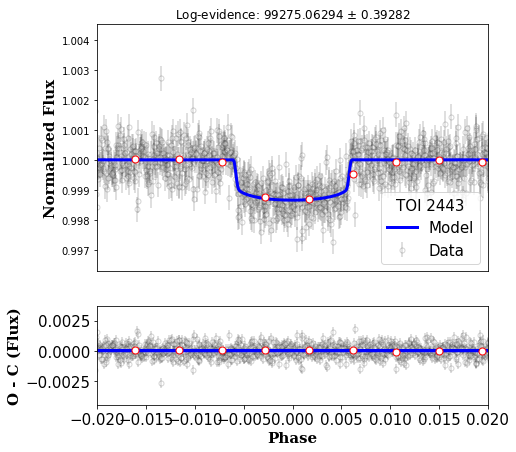

In [8]:
# ------------------------------------------------------------------------------------------
# Plotting the Graph
f, (f1, f2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [5,2]})
f.set_size_inches(7,7)
# ------------------------------------------------------------------------------------------

f1.errorbar(phases0, dataset.data_lc['TESS'], yerr= dataset.errors_lc['TESS'],\
             fmt='ko', mfc = 'white',markersize=5, alpha = 0.17, zorder = 1, label = "Data") # Plot whole data set in background
f1.plot(phases0[idx0],transit_model[idx0], color='b', lw = 3, zorder = 2, label = "Model")   # Plot the model 
f1.errorbar(p_bin, y_bin, yerr = yerr_bin, fmt='ro', mfc = 'white',markersize=7, zorder = 3) # Plot the binned data for reference

f1.set_title('Log-evidence: {0:.5f} $\pm$ {1:.5f}'.format(results.posteriors['lnZ'],results.posteriors['lnZerr']))
f1.set_ylabel('Normalized Flux',fontdict=font1, weight = "bold",fontsize="15")
f1.legend(title = Target_Star, loc = "lower right", fontsize = 15, title_fontsize = 15)

f1.set_xticks([])
plt.yticks(fontsize = 15)

f1.set_xlim([-0.02, 0.02])
#f1.set_ylim([0.950, 1.035])

# ---------------------------------------------------------------------------------------------
# Residual Plot
# ---------------------------------------------------------------------------------------------

f2.errorbar(phases0, transit_model - dataset.data_lc['TESS'], yerr= dataset.errors_lc['TESS'],\
             fmt='ko', mfc = 'white',markersize=5, alpha = 0.17, zorder = 1)

f2.plot(phases0, np.zeros(np.size(phases0)), color='b', lw = 3, zorder = 2)

f2.errorbar(p_bin1, y_bin1, yerr = yerr_bin1, fmt='ro', mfc = 'white',markersize=7, zorder = 3)

f2.set_xlabel('Phase',fontdict=font1, weight = "bold",fontsize="15")
f2.set_ylabel('O - C (Flux)',fontdict=font1, weight = "bold",fontsize="15")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

f2.set_xlim([-0.02, 0.02])
#f2.set_ylim([-0.003, 0.003])

# Save figure to output folder
f.savefig(os.path.join(output_folder, 'TOI_'+Target_Star[4:]+'_Transit.jpeg'), format='jpeg', dpi=600, bbox_inches = 'tight')

# Output File

In [6]:
# Different Paths to save the processed data

dat_file = 'TOI_'+Target_Star[4:]+'_Global_Fit/posteriors.dat'
parafile = 'TOI_'+Target_Star[4:]+'_Global_Fit/Parameters.txt'
latexfile = 'TOI_'+Target_Star[4:]+'_Global_Fit/Latex_TOI_'+Target_Star[4:]+'.tex'

dat_excel = pd.read_table(dat_file)
my_xlsx = dat_excel.to_excel('TOI_'+Target_Star[4:]+'_Global_Fit/Parameters.xlsx')

op_data = pd.read_excel('TOI_'+Target_Star[4:]+'_Global_Fit/Parameters.xlsx')

median_val = op_data[op_data.columns.values[3]]
upper_err = op_data[op_data.columns.values[5]]
lower_err = op_data[op_data.columns.values[7]]

In [7]:
with open(dat_file, 'r') as file:
    text = file.read()
    print(text)

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 15.6692133587 	 	 0.0014575977 	 	 0.0014028743
t0_p1              	 	 2459148.0989498729 	 	 0.0011354871 	 	 0.0011209212
r1_p1              	 	 0.5329117897 	 	 0.1233568375 	 	 0.1239747791
r2_p1              	 	 0.0347320061 	 	 0.0006719847 	 	 0.0006354414
p_p1               	 	 0.0347320061 	 	 0.0006719847 	 	 0.0006354414
b_p1               	 	 0.2993676846 	 	 0.1850352563 	 	 0.1859621687
inc_p1             	 	 89.3452105365 	 	 0.4150843343 	 	 0.5016076659
q1_TESS            	 	 0.1551015602 	 	 0.1734662135 	 	 0.0822596513
q2_TESS            	 	 0.3836435710 	 	 0.3609196971 	 	 0.2654705671
a_p1               	 	 26.1509598492 	 	 1.0381255512 	 	 2.1535529389
mflux_TESS         	 	 -0.0000126269 	 	 0.0000041007 	 	 0.0000039110
sigma_w_TESS       	 	 312.1708390335 	 	 4.7425251752 	 	 4.7156707972



# Calculation of Planetary Parameters

## 1. Constants & Conversions

In [9]:
# ----------------------------------------------------------------------------------------------
# Define Constants
# ----------------------------------------------------------------------------------------------

PI = np.pi                 # pi
G = 6.67*10**(-11)         # Gravitational Constant
AU = 1.496*10**(11)        # Astronomical Unit
M_S = 1.989*10**(30)       # Solar Mass
M_J = 1.898*10**(27)       # Jupiter Mass
M_E = 5.97219*10**(24)     # Earth Mass

R_S = 6.9634*10**(8)       # Solar Radius
R_J = 6.9911*10**(7)       # Jupiter Radius
R_E = 6371000              # Earth Radius
 

# Conversions
d2s = 24*3600              # Days to Seconds (for orbital period)
d2r = PI/180               # Degree to Radian (for inclination angle and Argument of Periastron)
rjtore = R_J/R_E           # Convert Jupiter Radius to Earth Radius
jmtoem = M_J/M_E           # Convert Jupiter mass to Earth mass

## 2. Planetary Parameters obtained from the Juliet Run

In [10]:
m1 = mass_of_the_host_star_in_solar_masses*M_S
r1 = radius_of_the_host_star_in_solar_radius*R_S
T1 = temperature_of_the_host_star


P, Pu, Pl = [median_val[0]*d2s, upper_err[0]*d2s, lower_err[0]*d2s]                # Orbital Period

ars, arsu, arsl = [median_val[9], upper_err[9], lower_err[9]]                      # Orbital Semi-major Axis

t0, t0u, t0l = [median_val[1], upper_err[1], lower_err[1]]                         # Epoch Time

rprs, rprsu, rprsl = [median_val[4], upper_err[4], lower_err[4]]                   # Fractional Radius

b, bu, bl = [median_val[5], upper_err[5], lower_err[5]]                            # Impact Parameter

i, iu, il = [median_val[6]*d2r, upper_err[6]*d2r, lower_err[6]*d2r]                # Inclination Angle

#ecc, eccu, eccl = [median_val[14], upper_err[14], lower_err[14]]                   # Eccentricity

#omega, omegau, omegal = [median_val[15]*d2r, upper_err[15]*d2r, lower_err[15]*d2r] # Argument of Periastron

## 3. Calculation of rest of the parameters

In [11]:
# Transit Depth
delta = rprs**2
deltau = (rprs + rprsu)**2 - delta
deltal = delta - (rprs - rprsl)**2 


# Radius
Rp = rprs*r1
Rpu = (rprs + rprsu)*r1 - Rp
Rpl = Rp - (rprs - rprsl)*r1 


# Semi-major Axis
a = ars*r1
au = (ars + arsu)*r1 - a
al = a - (ars - arsl)*r1


# Equilibrium Temperature
Teq = T1*sqrt(r1/(2*a))
Tequ = T1*sqrt(r1/(2*(a - al))) - Teq
Teql = Teq - T1*sqrt(r1/(2*(a + au)))


# Transit Duration
Td = (P/PI)*np.arcsin(np.sqrt(1 + rprs - b**2)/(np.sqrt(1 - (np.cos(i))**2)*ars))
Tdu = ((P - Pl)/PI)*np.arcsin(np.sqrt(1 + rprs - rprsl - (b - bl)**2)/(np.sqrt(1 - (np.cos(i - il))**2)*(ars - arsl))) - Td
Tdl = Td - ((P + Pu)/PI)*np.arcsin(np.sqrt(1 + rprs + rprsu - (b + bu)**2)/(np.sqrt(1 - (np.cos(i + iu))**2)*(ars + arsu)))


# Insolation Flux
S = luminosity*(AU/a)**2
Su = (luminosity+l_err)*(AU/(a-al))**2 - S
Sl = S - (luminosity-l_err)*(AU/(a+au))**2

## 4. Limb Darkening Parameters

In [12]:
# Limb Darkening Parameters

# Store posterior samples for q1 and q2:
q1, q2 = results.posteriors['posterior_samples']['q1_TESS'],\
results.posteriors['posterior_samples']['q2_TESS']
# Transform back to (u1,u2):
u1, u2 = juliet.utils.reverse_ld_coeffs('quadratic', q1, q2)

# Plot medians and errors implied by the posterior:
u1m,u1u,u1l = juliet.utils.get_quantiles(u1)
u2m,u2u,u2l = juliet.utils.get_quantiles(u2)

# List of the Calculated Parameters

In [13]:
mydata = [["P", "Period (days)", P/d2s, Pu/d2s, Pl/d2s],\
          ["R_P", "Radius (Jupiter Radius)", Rp/R_J, Rpu/R_J, Rpl/R_J], \
          ["R_P", "Radius (Earth Radius)", Rp/R_E, Rpu/R_E, Rpl/R_E], \
          ["T_C","Epoch Time (BJD)", t0, t0u, t0l], \
          ["T_dur", "Transit Duration (days)", Td/(3600*24), Tdu/(3600*24), Tdl/(3600*24)], \
          ["a","Semi-major Axis (AU)", a/AU, au/AU, al/AU], \
          ["i", "Inclination (Degrees)", i*180/PI, iu*180/PI, il*180/PI], \
          ["e", "Eccentricity", "0 (Fixed)"], \
          ["w", "Argument of Periastron (Degrees)", "90 (Fixed)"], \
          ["T_eqq", "Equilibrium Temperature (K)", Teq, Tequ, Teql], \
          ["S", "Insolation (S_E)", S, Su, Sl], \
          ["R_p/R_s", "Radius of planet in stellar radii", rprs, rprsu, rprsl], \
          ["a/R_s", "Semi-major axis in stellar radii", ars, arsu, arsl], \
          ["Delta", "Transit Depth (Fraction)", delta, deltau, deltal], \
          ["b", "Impact Parameter",b ,bu , bl], \
          ["u1", "Limb Darkening Parameter", u1m, u1u-u1m, u1m-u1l], \
          ["u2", "Limb Darkening Parameter", u2m, u2u-u2m, u2m-u2l]
         ]


with open(parafile, "w") as f:
    print(tabulate(mydata,headers = ["Parameters", "Description (Unit)", "Median", "Upper 68 CI", "Lower 68 CI"], \
                                    tablefmt="simple", numalign = "center", stralign = "center"), file=f)

with open(parafile, "r") as para:
    print(para.read())

 Parameters          Description (Unit)                 Median          Upper 68 CI    Lower 68 CI
------------  ---------------------------------  --------------------  -------------  -------------
     P                  Period (days)             15.669213358700002     0.0014576     0.00140287
    R_P            Radius (Jupiter Radius)       0.25327073023196706    0.00490021     0.00463373
    R_P             Radius (Earth Radius)         2.7792199060189997     0.0537715      0.0508474
    T_C               Epoch Time (BJD)            2459148.098949873     0.00113549     0.00112092
   T_dur           Transit Duration (days)       0.18547251142436125     0.0246507      0.0212715
     a              Semi-major Axis (AU)          0.0891162059659609    0.00353768     0.00733879
     i              Inclination (Degrees)           89.3452105365        0.415084       0.501608
     e                  Eccentricity                  0 (Fixed)
     w        Argument of Periastron (Degrees)      

# Visualization of Planetary System

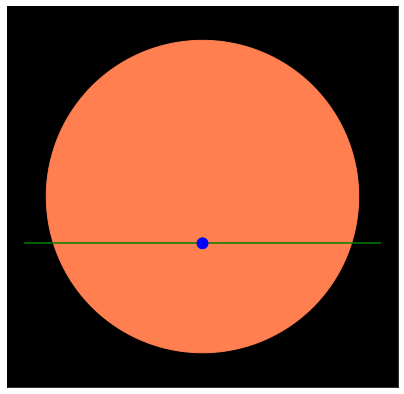

In [14]:
theta = np.linspace(0,2*PI,1000)
target_star_radii = radius_of_the_host_star_in_solar_radius
planet_radii = Rp/R_S
temp = temperature_of_the_host_star

if i*180/PI >90:
    b = -b

x = target_star_radii*np.sin(theta)
y = target_star_radii*np.cos(theta)

x1 = planet_radii*np.sin(theta)
y1 = planet_radii*np.cos(theta) - b*target_star_radii

xline = np.linspace(-(max(x)+0.1),(max(x)+0.1),100)
yline = -b*target_star_radii*np.ones(np.size(xline))


if temp > 30000:
    col = 'paleturquoise'
elif (temp > 10000) & (temp <= 30000):
    col = 'azure'
elif (temp > 7500) & (temp <= 10000):
    col = 'white'
elif (temp > 6000) & (temp <= 7500):
    col = 'lightyellow'
elif (temp > 5200) & (temp <= 6000):
    col = 'yellow'
elif (temp > 3700) & (temp <= 5200):
    col = 'coral'
elif (temp > 2400) & (temp <= 3700):
    col = 'tomato'
else:
    col = 'red'
    
    
plt.fill(x,y, zorder = 1, c = col)
plt.fill(x1,y1, zorder = 3, c = 'b')
plt.plot(xline,yline, zorder = 2, c = 'green')

plt.axis('equal')

plt.gca().set_facecolor('k')
plt.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
fig=plt.gcf()
fig.set_size_inches(7,7)

fig.savefig(os.path.join(output_folder, 'TOI_'+Target_Star[4:]+'_Visuals.jpeg'), format='jpeg', dpi=600, bbox_inches = 'tight')

# LaTeX Script 

In [ ]:
with open(latexfile, "w") as latex:
    print("\\documentclass[12pt, a4paper]{book}", file = latex)
    
    print("\\usepackage{amsmath}", file = latex)
    print("\\usepackage{geometry}", file = latex)
    print("\\usepackage{graphicx}", file = latex)
    print("\\usepackage{xurl}", file = latex)
    print("\\geometry{paper=a4paper, top=3cm, bottom=3cm, left=2.6cm, right=2.6cm,", \
           "headheight=14pt,footskip=1.4cm, headsep=10pt}", file = latex)
    
    print(" ", file = latex)
    
    print("\\begin{document}", file = latex)
    
    print(" ", file = latex)
    
    print("\\begin{center}", file = latex)
    print("{\\Huge \\textbf{Modelling Transit Light Curve through \\texttt{Juliet}}}\\\\", file = latex)
    print("\\vspace*{1cm}", file = latex)
    print("{\\Huge \\textbf{",Target_Star,"}}", file = latex)
    print("\\end{center}", file = latex)
    
    print(" ", file = latex)
    print("\\vspace*{0.6cm}", file = latex)
    print(" ", file = latex)
    
    print("\\begin{center}", file = latex)
    print("\\includegraphics[scale=0.5]{TOI_"+Target_Star[4:]+"_Visuals}", file = latex)
    print("\\end{center}", file = latex) 
    
    print(" ", file = latex)
    print("\\vspace*{0.6cm}", file = latex)
    print(" ", file = latex)
    
    print("\\begin{center}", file = latex)
    print("\\includegraphics[scale=0.6]{TOI_"+Target_Star[4:]+"_Transit}", file = latex)
    print("\\end{center}", file = latex)
    
    print(" ", file = latex)
    
    print("\\newpage", file = latex) 
    print("\\begin{center}", file = latex)
    print("{\\large \\textbf{Stellar Parameters}}", file = latex)
    print("\\end{center}", file = latex)
    print("\\begin{itemize}", file = latex)
    print("\\item Magnitude (V) : ", magnitude, "$\pm$", mag_err, file = latex)
    print("\\item Mass of the Star ($M_*$) : ", mass_of_the_host_star_in_solar_masses, "$\pm$", m_err, "$M_\odot$", file = latex)
    print("\\item Radius of the Star ($R_*$) : ", radius_of_the_host_star_in_solar_radius, "$\pm$", r_err, "$R_\odot$", file = latex)
    print("\\item Temperature (T) : ", temperature_of_the_host_star, "$\pm$", t_err, "K", file = latex)
    print("\\item Luminosity (L) : ", luminosity, "$\pm$", l_err, "$L_\odot$", file = latex)
    print("\\end{itemize}", file = latex)

    print("\\vspace*{0.6cm}", file = latex)
    print("\\begin{center}", file = latex)
    print("{\\large \\textbf{Median values and 68\\% confidence interval from \\texttt{Juliet}}}", file = latex)
    print("\\end{center}", file = latex)
    
    print(" ", file = latex)
    
    print("\\begin{center}", file = latex)
    print("\\begin{tabular}{c c c}", file = latex)

    print("\hline", file = latex)
    print("\hline", file = latex)
    
    print("Parameters &","Description (Unit) &","Values \\\\", file = latex)
    print("\hline", file = latex)

    print(" & & \\\\", file = latex)
    print("P &","Period (days) &",f"{P/d2s:0.6f}","$^{+",f"{Pu/d2s:0.6f}","} _{-",f"{Pl/d2s:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$R_P$ &","Radius ($R_J$) &",f"{Rp/R_J:0.6f}","$^{+",f"{Rpu/R_J:0.6f}","} _{-",f"{Rpl/R_J:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$R_P$ &","Radius ($R_E$) &",f"{Rp/R_E:0.6f}","$^{+",f"{Rpu/R_E:0.6f}","} _{-",f"{Rpl/R_E:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$T_C$ &","Epoch Time (BJD) &",f"{t0:0.6f}","$^{+",f"{t0u:0.6f}","} _{-",f"{t0l:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$T_d$ &","Transit Duration (days) &",f"{Td/(3600*24):0.6f}","$^{+",f"{Tdu/(3600*24):0.6f}", \
          "} _{-",f"{Tdl/(3600*24):0.6f}","}$ \\\\", file = latex)
    
    print(" & & \\\\", file = latex)
    print("$a$ &","Semi-major Axis (AU) &",f"{a/AU:0.6f}","$^{+",f"{au/AU:0.6f}","} _{-",f"{al/AU:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$i$ &","Inclination (Degree) &",f"{i*180/PI:0.6f}","$^{+",f"{iu*180/PI:0.6f}","} _{-",f"{il*180/PI:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$e$ &","Eccentricity &","0 (Fixed) \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$\omega$ &","Argument of Periastron (Degree) &","90 (Fixed) \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$T_{eqq}$ &","Equilibrium Temperature (K) &",f"{Teq:0.6f}","$^{+",f"{Tequ:0.6f}","} _{-",f"{Teql:0.6f}","}$ \\\\", file = latex)
    
    print(" & & \\\\", file = latex)
    print("$S$ &","Insolation ($S_E$) &",f"{S:0.6f}","$^{+",f"{Su:0.6f}","} _{-",f"{Sl:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$R_P/R_S$ &","Radius of planet in stellar radii &",f"{rprs:0.6f}","$^{+",f"{rprsu:0.6f}", \
          "} _{-",f"{rprsl:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$a/R_S$ &","Semi-major axis in stellar radii &",f"{ars:0.6f}","$^{+",f"{arsu:0.6f}","} _{-",f"{arsl:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$\delta$ &","Transit Depth (Fraction) &",f"{delta:0.6f}","$^{+",f"{deltau:0.6f}","} _{-",f"{deltal:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$b$ &","Impact Parameter &",f"{b:0.6f}","$^{+",f"{bu:0.6f}","} _{-",f"{bl:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$u_1$ &","Limb Darkening Parameter &",f"{u1m:0.6f}","$^{+",f"{u1u - u1m:0.6f}","} _{-",f"{u1m - u1l:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$u_2$ &","Limb Darkening Parameter &",f"{u2m:0.6f}","$^{+",f"{u2u - u2m:0.6f}","} _{-",f"{u2m - u2l:0.6f}","}$ \\\\", file = latex)

    print("\\end{tabular}", file = latex)
    print("\\end{center}", file = latex)
    
    print(" ", file = latex)
    print("\\end{document}", file = latex)


# Run the LaTeX File
texfile = "Latex_TOI_"+Target_Star[4:]+".tex"
os.chdir(r'TOI_'+Target_Star[4:]+'_Global_Fit')
print(os.getcwd())
os.system("pdflatex %s" %texfile)
print("Saved the PDF")
os.chdir('..')
print(os.getcwd())